In [85]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import petl as etl
import anhima
import zarr
import allel
import itertools
import random
import seaborn as sns
import petlx.bio
import csv
import scipy
import intervaltree

In [ ]:
call = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic')
out_alleles = h5py.File('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles.h5')
ac_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/phase2_biallel_allele_count.zarr/')
out_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.zarr/')
annotation = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic_snpeff/')
samples = list(call['3L/samples'])
contigs = ['3L', '3R', '2R', '2L', 'X']
samples = [str(s) for s in call["3L"]["samples"][:]]
tbl_samples = etl.fromcsv('/mnt/70D89269D8922CFA/Genomes/meta/samples.meta.txt', delimiter='\t')

In [3]:
tbl_samples

ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.7,ERS311886,5.60858,-1.54926
AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


----------------------

In [4]:
m = tbl_samples.select(lambda r: r.m_s == 'M' and r.population == 'BFcol').values('ox_code').list()
s = tbl_samples.select(lambda r: r.m_s == 'S' and r.population == 'BFgam').values('ox_code').list()
index_m = [samples.index(i) for i in m]
index_s = [samples.index(i) for i in s]

In [5]:
print('coluzzii samples:', len(index_m), '\n', 'gambiae samples:', len(index_s))

coluzzii samples: 75 
 gambiae samples: 92


In [6]:
ann = {chrom: annotation[chrom]['variants/ANN_Annotation'][:] for chrom in contigs}

In [7]:
sel = {chrom: ((ann[chrom] != b'intergenic_variant') & (ann[chrom] != b'upstream_gene_variant') &
(ann[chrom] != b'downstream_gene_variant')) for chrom in contigs}

In [8]:
del ann

In [9]:
#Changed from GenotypeDaskArray to GenotypeChunkedArray
ga = {chrom: allel.GenotypeChunkedArray(call[chrom]['calldata/GT']) for chrom in contigs}

In [10]:
# bool biallelic and in genes
is_bial_genes = {chrom: sel[chrom] for chrom in contigs}

In [11]:
#filter to get only biallelic in genes
ga = {chrom: ga[chrom].compress(is_bial_genes[chrom], axis=0) for chrom in contigs}

In [12]:
# get just bf coluzzii individuals
gm = {chrom: ga[chrom].take(index_m, axis=1) for chrom in contigs}

In [13]:
#take an equal number of samples
random_index = random.sample(index_s, 75)
gs = {chrom: ga[chrom].take(index_s, axis=1) for chrom in contigs}

In [14]:
acm = {chrom: gm[chrom].count_alleles() for chrom in contigs}
seg_m = {chrom: acm[chrom].count_segregating() for chrom in contigs}
is_seg_m = {chrom: acm[chrom].is_segregating() for chrom in contigs}

In [15]:
acs = {chrom: gs[chrom].count_alleles() for chrom in contigs}
seg_s = {chrom: acs[chrom].count_segregating() for chrom in contigs}
is_seg_s = {chrom: acs[chrom].is_segregating() for chrom in contigs}

In [16]:
for chrom in contigs:
    print('seg sites coluzii chrom %s:' % chrom, seg_m[chrom])

seg sites coluzii chrom 3L: 2278983
seg sites coluzii chrom 3R: 3201821
seg sites coluzii chrom 2R: 3312912
seg sites coluzii chrom 2L: 2748896
seg sites coluzii chrom X: 1108436


In [17]:
for chrom in contigs:
    print('seg sites gambiae chrom %s:' % chrom, seg_s[chrom])

seg sites gambiae chrom 3L: 2759200
seg sites gambiae chrom 3R: 3754716
seg sites gambiae chrom 2R: 4386949
seg sites gambiae chrom 2L: 3157108
seg sites gambiae chrom X: 1418421


In [18]:
#allele frequency
af_gambiae = {chrom: acs[chrom].to_frequencies() for chrom in contigs}

In [19]:
#allele frequency
af_coluzzii = {chrom: acm[chrom].to_frequencies() for chrom in contigs}

In [20]:
outgroups = ['epir', 'chri', 'meru', 'mela']

In [66]:
pos = {chrom: call[chrom]['variants/POS'][:] for chrom in contigs}
pos_bial_genes = {chrom: np.compress(is_bial_genes[chrom], pos[chrom]) for chrom in contigs}

In [22]:
# af biallelic in genes
af_out = {}
for out in outgroups:
    af_out[out] = {}
    for chrom in contigs:
        allele_count = out_count[chrom][out][:]
        allele_count_bial_genes = np.compress(is_bial_genes[chrom], allele_count, axis=0)
        allele_number = allele_count_bial_genes.sum(axis=1)[:, np.newaxis]
        af_out[out][chrom] = np.where(allele_number > 0, allele_count_bial_genes / allele_number, 0)

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [23]:
#filter bial in genes
out_al = {}
for chrom in contigs:
    out_al[chrom] = {}
    for out in outgroups:
        out_al[chrom][out] = out_alleles[chrom][out][:]
        out_al[chrom][out] = np.compress(is_bial_genes[chrom], out_al[chrom][out])

In [24]:
assert out_al[chrom][out].shape[0] == af_out[out][chrom].shape[0]

In [25]:
def consensus_aa(chrom, out_alleles, outgroups):
    aa = None
    for out in outgroups:
        if aa is None:
            aa = out_alleles[chrom][out]
        else:
            loc_consensus = aa == out_alleles[chrom][out]
            aa[~loc_consensus] = b'.'
    return aa

In [26]:
aa = {chrom: consensus_aa(chrom, out_al, ['chri']) for chrom in contigs}

In [29]:
# load ag1000g alleles
ref = {chrom: call[chrom]['variants/REF'][:] for chrom in contigs}
alt = {chrom: call[chrom]['variants/ALT'][:] for chrom in contigs}

In [30]:
# filter for bial in genes
ref_bial_genes = {chrom: np.compress(is_bial_genes[chrom], ref[chrom]) for chrom in contigs}

alt_bial_genes = {chrom: np.compress(is_bial_genes[chrom], alt[chrom]) for chrom in contigs}

In [32]:
bool_aa_match = {chrom: (aa[chrom] != b'.') & ((aa[chrom] == ref_bial_genes[chrom]) | (aa[chrom] == alt_bial_genes[chrom])) for chrom in contigs}

In [49]:
for chrom in contigs:
    ref[chrom] = ref_bial_genes[chrom][bool_aa_match[chrom]]
    alt[chrom] = alt_bial_genes[chrom][bool_aa_match[chrom]]
    af_coluzzii[chrom] =  af_coluzzii[chrom].compress(bool_aa_match[chrom], axis=0)
    af_gambiae[chrom] = af_gambiae[chrom].compress(bool_aa_match[chrom], axis=0)
    aa[chrom] = aa[chrom][bool_aa_match[chrom]]
    pos_bial_genes[chrom] = pos_bial_genes[chrom][bool_aa_match[chrom]]
    out = 'chri'
    af_out[out][chrom] = af_out[out][chrom][bool_aa_match[chrom]]

In [50]:
bool_no_fixed = {chrom:(((af_out['chri'][chrom][:,1]  != 0) & (af_out['chri'][chrom][:,1] != 1)) 
                        ) for chrom in contigs}

In [52]:
af_gambiae_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_gambiae[chrom], axis=0) for chrom in contigs}
af_coluzzii_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_coluzzii[chrom], axis=0) for chrom in contigs}
af_novar_out = {}
for out in ['chri']:
        af_novar_out[out] = {chrom: np.compress(~bool_no_fixed[chrom], af_out[out][chrom], axis=0) for chrom in contigs}     

In [53]:
pos_bial_genes = {chrom: np.compress(~bool_no_fixed[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [54]:
def find_private_fixed_derived_gambiae(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_coluzzii[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                                   
                        

In [55]:
def find_private_fixed_derived_coluzzii(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_gambiae[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                 

In [56]:
chrom = 'X'
assert(af_gambiae_novar_out[chrom].shape[0] == af_gambiae_novar_out[chrom].shape[0] == pos_bial_genes[chrom].shape[0])

## Sanity Check

In [57]:
fixed_g = find_private_fixed_derived_gambiae(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_g['3L']

array([   65602,    79429,    79661,   191814,   198733,   198752,
         292047,   292180,   347135,   369309,   369431,   374670,
        9205524,  9229129,  9504017,  9504404,  9505301,  9509195,
        9682767,  9682775,  9698430, 10233176, 10233180, 10248996,
       10274453, 10276868, 10762090, 10883931, 10885668, 10885781,
       10904449, 10905431, 10905456, 11130795, 11213955, 11219708,
       11592775, 11592984, 11593513, 11653789, 33278285], dtype=int32)

In [58]:
fixed_c = find_private_fixed_derived_coluzzii(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_c['3L']

array([   78661,    80187,   123833,   127971,   129079,   129195,
         188358,   191903,   192086,   217520,   337366,   345225,
         345284,   345366,   372667,   375902,   376733,  9662785,
        9683196, 10243325, 10243327, 10248982, 10815812, 10883587,
       10904429, 10912700, 10913361, 10913514, 11591900, 11593332,
       11593543, 13009275, 13009470, 13009479, 13009657], dtype=int32)

In [59]:
loc_3L = np.in1d(pos_bial_genes['3L'], fixed_c['3L'])
np.compress(loc_3L, af_coluzzii_novar_out['3L'], axis=0)[:10]

array([[ 0.99333333,  0.00666667],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.98666667,  0.01333333]])

In [60]:
np.compress(loc_3L, af_gambiae_novar_out['3L'], axis=0)[:10]

array([[ 0.04891304,  0.95108696],
       [ 0.04891304,  0.95108696],
       [ 0.04891304,  0.95108696],
       [ 0.04347826,  0.95652174],
       [ 0.04891304,  0.95108696],
       [ 0.04891304,  0.95108696],
       [ 0.04891304,  0.95108696],
       [ 0.04891304,  0.95108696],
       [ 0.04891304,  0.95108696],
       [ 0.04891304,  0.95108696]])

In [61]:
np.compress(loc_3L, af_novar_out['chri']['3L'], axis=0)[:10,:2]

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

-----------------------------

## Stat

In [62]:
def identify_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP3.4.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == 'vectorbase|%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["web_id"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    return interval_join

In [63]:
identify_fixex_coluzzii = {chrom: identify_variants_per_gene(chrom, fixed_c, 'coluzzii_segreg') for chrom in contigs}

In [64]:
identify_fixex_gambiae = {chrom: identify_variants_per_gene(chrom, fixed_g, 'coluzzii_segreg') for chrom in contigs}

In [67]:
segreg_c = {chrom: np.compress(is_seg_m[chrom], pos_bial_genes[chrom]) for chrom in contigs}
segreg_g = {chrom: np.compress(is_seg_s[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [71]:
def count_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP3.4.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == 'vectorbase|%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["web_id"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    aggregate = interval_join.aggregate('genes', len).rename('value', species)
    return aggregate

In [72]:
#A
count_segreg_coluzzii = {chrom: count_variants_per_gene(chrom, segreg_c, 'coluzzii_segreg') for chrom in contigs}

In [73]:
#B
count_segreg_gambiae = {chrom: count_variants_per_gene(chrom, segreg_g, 'gambiae_segreg') for chrom in contigs}

In [74]:
#C
count_fixed_coluzzii = {chrom: count_variants_per_gene(chrom, fixed_c, 'coluzzii_fixed') for chrom in contigs}

In [75]:
#D
count_fixed_gambiae = {chrom: count_variants_per_gene(chrom, fixed_g, 'gambiae_fixed') for chrom in contigs}

In [76]:
# join (A and C) - (B and D)
joi_seg_fix_coluzzii = {chrom: count_fixed_coluzzii[chrom].join(count_segreg_coluzzii[chrom], key='genes') for chrom in contigs}
joi_seg_fix_gambiae  = {chrom: count_fixed_gambiae[chrom].join(count_segreg_gambiae[chrom], key='genes') for chrom in contigs}

In [77]:
# calculate the ratio for each gene
joi_seg_fix_coluzzii= {chrom: joi_seg_fix_coluzzii[chrom].addfield('A/C (i.e.seg/fix)', lambda r: r.coluzzii_segreg / r.coluzzii_fixed)
                       for chrom in contigs}
joi_seg_fix_gambiae= {chrom: joi_seg_fix_gambiae[chrom].addfield('B/D (i.e.seg/fix)', lambda r: r.gambiae_segreg / r.gambiae_fixed)
                       for chrom in contigs}
joi_seg_fix_coluzzii['2R'].display()
joi_seg_fix_gambiae['2R'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix)
AGAP001658,2,1773,886.5
AGAP001674,5,2322,464.4
AGAP001675,1,24,24.0
AGAP001683,22,13413,609.6818181818181
AGAP001684,1,383,383.0


genes,gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP001674,1,3527,3527.0
AGAP001683,9,18711,2079.0
AGAP001824,2,6464,3232.0
AGAP002152,1,1196,1196.0
AGAP002232,1,944,944.0


In [78]:
etl.rowlengths(joi_seg_fix_gambiae['X'])

length,count
4,34


In [79]:
# calculate ABCD genome wide (in all genes with both fixed and segregating variants)
A_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_segreg')[2] for chrom in contigs])
C_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_fixed')[2] for chrom in contigs])
B_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_segreg')[2] for chrom in contigs])
D_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_fixed')[2] for chrom in contigs])

In [80]:
# calculate A/C and B/D genome wide
AC_geno_wide = A_geno_wide_coluzzii / C_geno_wide_coluzzii
print('\n', 'A genome wide: ', A_geno_wide_coluzzii, '\n', 'C genome wide: ', C_geno_wide_coluzzii, '\n', 'A/C genome wide: ', AC_geno_wide)
BD_geno_wide = B_geno_wide_gambiae / D_geno_wide_gambiae
print('\n', 'B genome wide: ', B_geno_wide_gambiae, '\n', 'D genome wide: ', D_geno_wide_gambiae, '\n', 'B/D genome wide: ', BD_geno_wide)


 A genome wide:  74270.0 
 C genome wide:  503.0 
 A/C genome wide:  147.6540755467197

 B genome wide:  84429.0 
 D genome wide:  136.0 
 B/D genome wide:  620.8014705882352


In [89]:
def get_conti(chrom, species, joi_seg_fix, seg_geno_wide, fixed_geno_wide):
    conti_tbl = {}
    for rec in joi_seg_fix[chrom].records():
        if species == 'coluzzii':
            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            gene = rec.genes
            conti_tbl[gene] = [[A, C], [seg_geno_wide, fixed_geno_wide]]
        if species == 'gambiae':
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[gene] = [[B, D], [seg_geno_wide, fixed_geno_wide]]
    return conti_tbl

In [90]:
def perform_pear_chi(species):
    pear_chi = {}
    conti_tbl = {}
    for chrom in contigs:
        if species == 'coluzzii':
            conti_tbl[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
        if species == 'gambiae':
            conti_tbl[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
        pear_chi[chrom] = {}
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [91]:
pear_chi_coluzzii = perform_pear_chi('coluzzii')
pear_chi_gambiae = perform_pear_chi('gambiae')

In [94]:
conti_tbl_coluzzii = {}
conti_tbl_gambiae = {}
for chrom in contigs:
    conti_tbl_gambiae[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    conti_tbl_coluzzii[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)

In [95]:
with open('/home/randomx/hka/gambiae_hka_summary_v2.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_g', 'pri_der_fix_g', 'score_g']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_gambiae[chrom].items():
            row = [chrom, gene, conti_tbl_gambiae[chrom][gene][0][0], conti_tbl_gambiae[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


In [103]:
with open('/home/randomx/hka/coluzzii_hka_summary.tab_v2.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_c', 'pri_der_fix_c', 'score_c']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_coluzzii[chrom].items():
            row = [chrom, gene, conti_tbl_coluzzii[chrom][gene][0][0], conti_tbl_coluzzii[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


------------------------------------------------------------

In [100]:
hka_gambiae = etl.fromtsv('/home/randomx/hka/gambiae_hka_summary_v2.tab', delimiter='\t')
hka_gambiae.convert('score_g', float).select(lambda rec: rec.score_g >= 1.3).displayall()

chrom,gene,segreg_g,pri_der_fix_g,score_g
3L,AGAP010310,147,2,1.97555144179
3L,AGAP010314,217,3,3.44693751872
3R,AGAP010296,187,3,4.06719143848
3R,AGAP010302,54,2,5.51427678541
3R,AGAP010295,205,4,7.13047055816
3R,AGAP010289,19,2,14.6459904016
3R,AGAP007762,55,2,5.4166653923
3R,AGAP010293,88,4,17.0787892782
3R,AGAP010290,195,4,7.52612592255
2R,AGAP002790,4882,1,1.61198488551


In [104]:
hka_coluzzii = etl.fromtsv('/home/randomx/hka/coluzzii_hka_summary.tab_v2.tab', delimiter='\t')
hka_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c
3L,AGAP010314,120,3,1.18063315344
3L,AGAP010310,118,2,0.355983196839
3L,AGAP010311,50,1,0.103073566785
3L,AGAP010312,186,3,0.558796245453
3R,AGAP007734,111,1,0.114006537359
3R,AGAP010296,177,7,5.61085390395
3R,AGAP007733,48,1,0.115460042102
3R,AGAP007732,193,10,11.330766375
3R,AGAP010297,38,2,1.75664295687
3R,AGAP010293,69,10,33.6322381422


In [105]:
hka_gambiae.convert('score_g', float).select(lambda r: (r.chrom == 'X') & (r.score_g >= 1.3)).rowlengths() 

length,count
5,12


In [106]:
hka_coluzzii.convert('score_c', float).select(lambda r: (r.chrom == 'X') & (r.score_c >= 1.3)).rowlengths() 

length,count
5,30


-----------------------------

## Distruptive selection

In [108]:
direct_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    #.select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True)
    )
direct_select.tocsv('/home/randomx/hka/putative_directional_selection_v2.tab', delimiter='\t')
direct_select.display(10)

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
X,AGAP001094,130,35,206.970729971,170,1,0.173804815,207.144534786
X,AGAP001052,150,29,129.417196325,280,1,0.0245232245855,129.44171954958549
3R,AGAP010293,69,10,33.6322381422,88,4,17.0787892782,50.7110274204
X,AGAP001091,111,13,35.9726653743,85,1,0.477774269816,36.450439644116
X,AGAP001092,11,2,5.76277484319,8,2,30.513375757,36.27615060019
X,AGAP001061,132,14,35.1333128376,247,2,1.07209769888,36.20541053648
3R,AGAP010295,195,9,8.83985858936,205,4,7.13047055816,15.970329147520001
2R,AGAP001683,13413,22,11.5929986593,18711,9,3.53091732414,15.12391598344
X,AGAP001084,53,5,10.2949239909,63,2,4.74206311814,15.036987109039998
2L,AGAP005165,8321,4,11.1879804931,8229,2,2.45396147936,13.64194197246


In [109]:
direct_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    .select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True))
direct_select.tocsv('/home/randomx/hka/putative_directional_selection_v2.tab', delimiter='\t')
direct_select.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
3R,AGAP010293,69,10,33.6322381422,88,4,17.0787892782,50.7110274204


- AGAP001039 CYP307A1
- AGAP001050 chondroitin polymerizing factor Tripet

## Indentify genes which experienced private selection

In [110]:
hka_gambiae_coluzzii = hka_coluzzii.outerjoin(hka_gambiae, key=['chrom', 'gene']).convert(['score_g', 'score_c'], float)
priv_sel_coluzzii =  (hka_gambiae_coluzzii.selectne('score_c', None).convert('score_g', {None: 0})
                     .select(lambda r: r.score_c >= 1.3 and r.score_g <= 1.3).sort('score_c', reverse=True))
priv_sel_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP001094,130,35,206.970729971,170,1,0.173804815
X,AGAP001052,150,29,129.417196325,280,1,0.0245232245855
X,AGAP001093,147,22,77.7819540992,None,None,0
X,AGAP001039,73,14,61.9447631246,None,None,0
X,AGAP001090,60,12,54.7939828839,None,None,0
X,AGAP001091,111,13,35.9726653743,85,1,0.477774269816
X,AGAP001061,132,14,35.1333128376,247,2,1.07209769888
X,AGAP001082,131,13,30.4191198843,None,None,0
X,AGAP001083,38,7,28.5072699456,None,None,0
X,AGAP001026,79,8,18.637175062,None,None,0


In [111]:
priv_sel_gambiae =  (hka_gambiae_coluzzii.selectne('score_g', None).convert('score_c', {None: 0})
                     .select(lambda r: r.score_g >= 1.3 and r.score_c <= 1.3).sort('score_g', reverse=True))
priv_sel_gambiae.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP001051,None,None,0,8,2,30.513375757
3R,AGAP010289,None,None,0,19,2,14.6459904016
X,AGAP001050,15,1,0.63691436984,25,2,11.4191397378
3R,AGAP010290,163,2,0.147753814729,195,4,7.52612592255
X,AGAP000949,None,None,0,43,2,6.86878543393
3R,AGAP010302,42,1,0.158084766339,54,2,5.51427678541
3R,AGAP007762,36,1,0.211653822369,55,2,5.4166653923
X,AGAP001042,8,1,1.1340162265,10,1,3.5230686411
3L,AGAP010314,120,3,1.18063315344,217,3,3.44693751872
2R,AGAP003070,None,None,0,6302,1,2.15006325016


## Plot genome wide HKA

In [112]:
def center_pos(r):
    start = r.start
    end = r.end
    center = ((end - start) / 2) + start
    return int(center)

In [114]:
tbl_genes  = (etl
    .fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP3.4.gff3.gz')
    .unpackdict('attributes')
    .cut(2,3,4,10)
    .select(lambda rec: rec.type == 'gene')
    .split('ID', 'vectorbase\|', ['ID', 'gene'])
    .cut(0,1,2,4)
    .addfield('center_gene', center_pos)
)
tbl_genes.display(10)

type,start,end,gene,center_gene
gene,157348,186936,AGAP004677,172142
gene,203779,205293,AGAP004678,204536
gene,207894,210460,AGAP004679,209177
gene,271285,271815,AGAP004680,271550
gene,358329,359280,AGAP004681,358804
gene,433503,461627,AGAP004682,447565
gene,485698,488369,AGAP004683,487033
gene,493039,493543,AGAP004684,493291
gene,493579,497632,AGAP004685,495605
gene,742004,747057,AGAP004686,744530


In [115]:
pos_hka_gambiae = hka_gambiae.join(tbl_genes, key='gene')
pos_hka_coluzzii = hka_coluzzii.join(tbl_genes, key='gene')

In [116]:
def plot_genome_hka(species, chrom):
    if species == 'gambiae':   
        tbl_plot = pos_hka_gambiae.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_g'].list()
    if species == 'coluzzii':
        tbl_plot = pos_hka_coluzzii.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_c'].list()
    fig, ax = plt.subplots(figsize=(15,2))
    x = tbl_plot['center_gene'].list()
    
    ax.set_ylabel('HKA test score', fontsize=14)
    ax.set_xlabel('Positions', fontsize=14)
    ax.set_title('An. gambiae chrom: %s' % chrom, fontsize=14)
    ax.plot(x, y, 'or')
    len_chrom = {'X': 244e5, '3R': 532e5, '3L': 42e6, '2R': 616e5, '2L':493e5}
    ax.set_xlim(0, len_chrom[chrom])
    if chrom == 'X':
        ax.set_ylim(0, 80)
    else:
        ax.set_ylim(0, 40)
    sns.despine(offset=10)

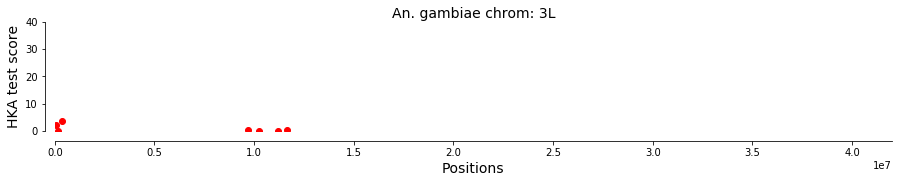

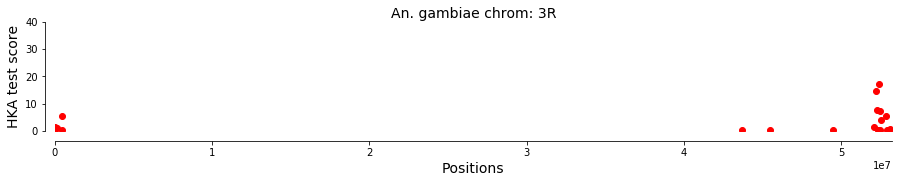

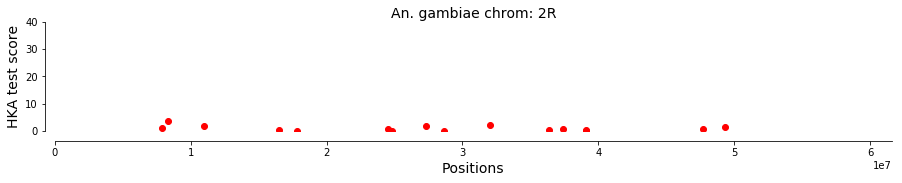

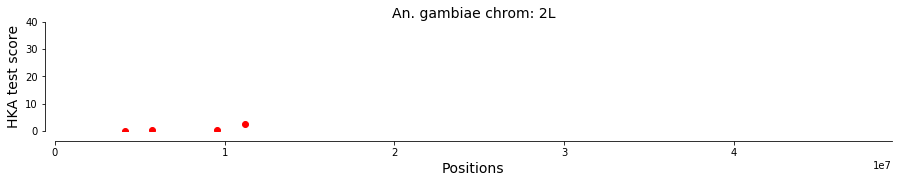

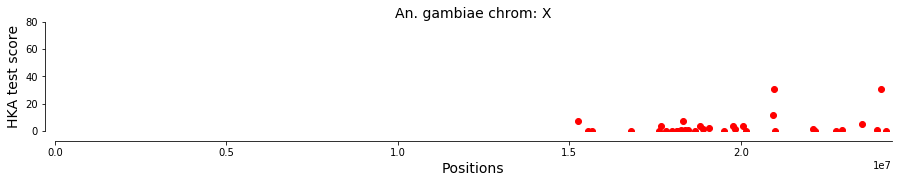

In [117]:
for chrom in contigs:
    plot_genome_hka('gambiae', chrom)

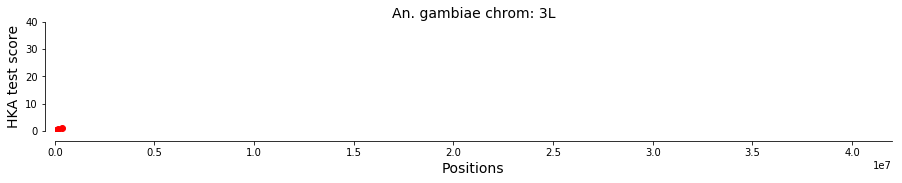

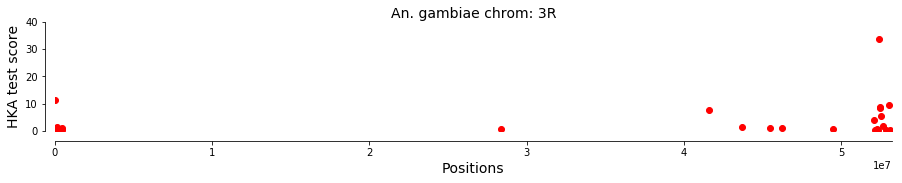

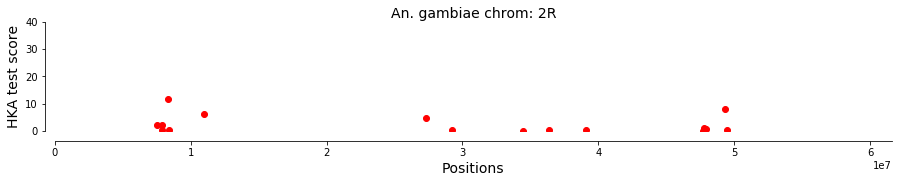

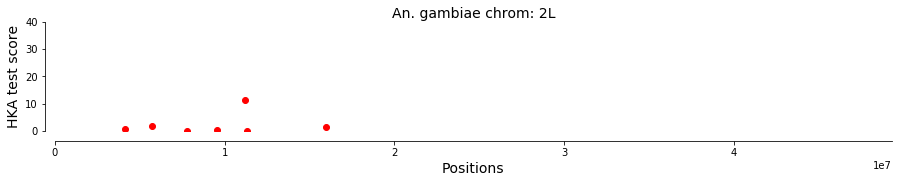

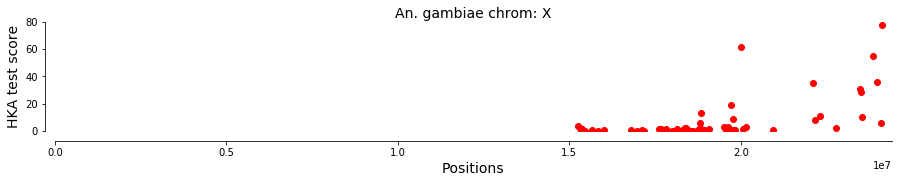

In [118]:
for chrom in contigs:
    plot_genome_hka('coluzzii', chrom)

## Plot seg fixed An coluzzii

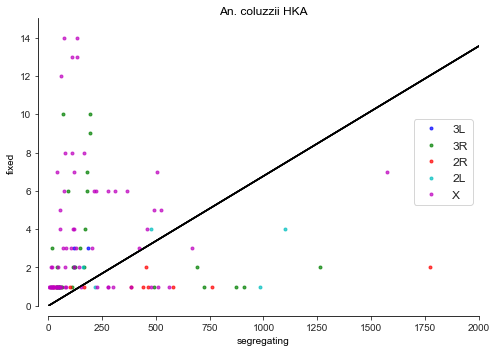

In [119]:
fig, ax = plt.subplots(figsize=(7,5))
for num, chrom in enumerate(contigs):
    
    colour = {0:'b', 1:'g', 2:'r', 3: 'c', 4:'m'}
    conti_tbl = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed,  colour[num] + '.', alpha=0.7, label=chrom)
    ax.plot([0, A_geno_wide_coluzzii], [0, C_geno_wide_coluzzii], 'k')
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('An. coluzzii HKA')
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    ax.legend(loc=7, fontsize='large')
    sns.despine(offset=10)

fig.tight_layout()

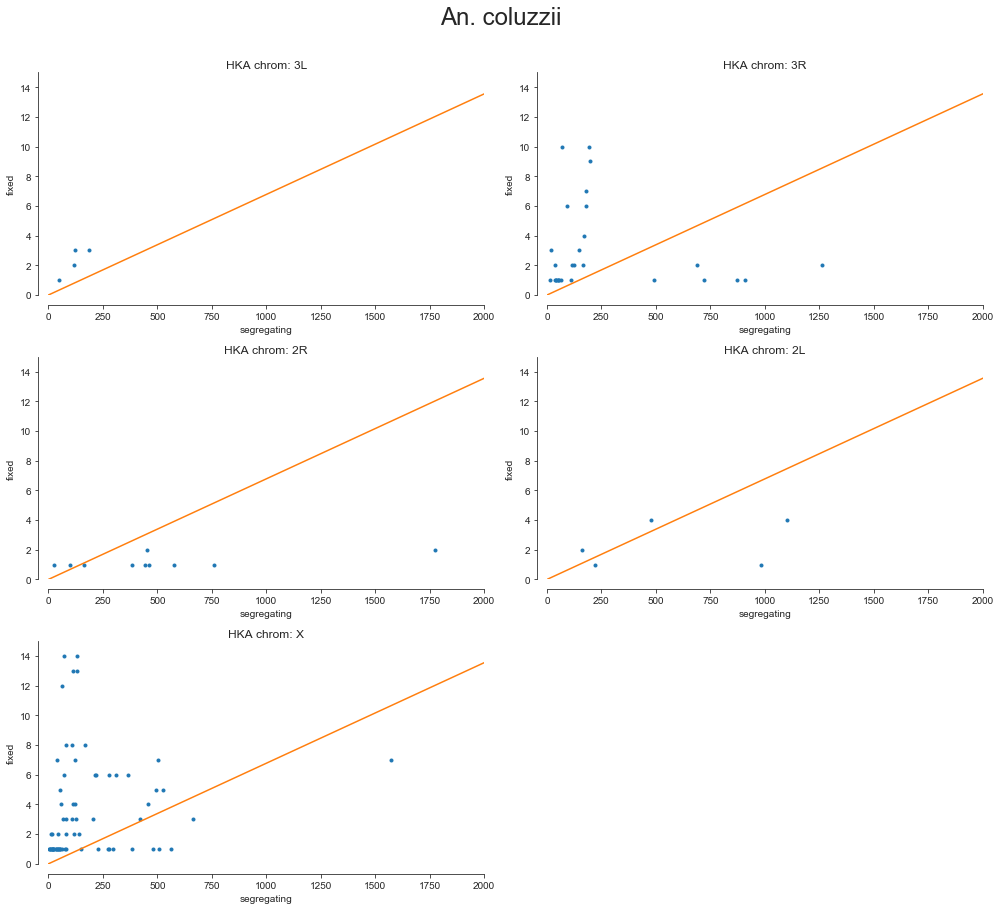

In [120]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    conti_tbl = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed, '.')
    ax.plot([0, A_geno_wide_coluzzii], [0, C_geno_wide_coluzzii])
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('HKA chrom: %s' % chrom)
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    sns.despine(offset=10)
fig.suptitle('An. coluzzii', y=1.05, fontsize=24)
fig.tight_layout()
fig.savefig('/home/randomx/hka/coluzzii.png', dpi=500)

## Plot seg fixed An. gambiae

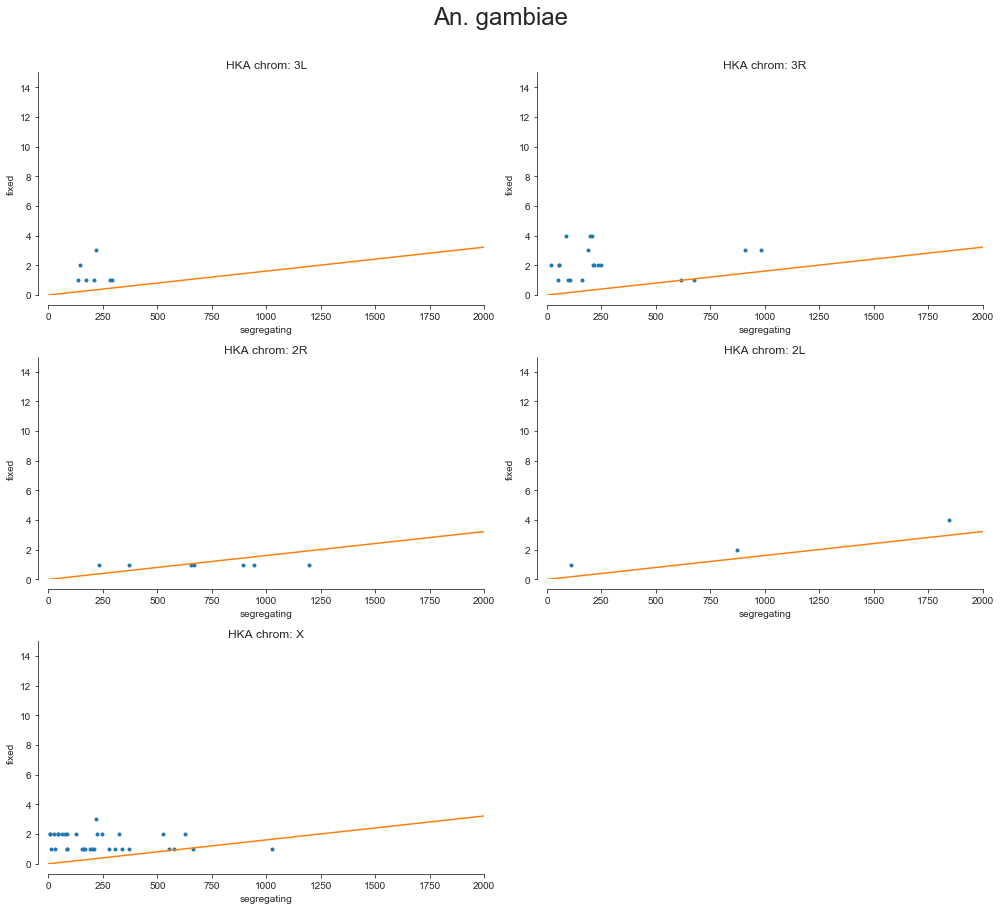

In [121]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    conti_tbl = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed, '.')
    ax.plot([0, B_geno_wide_gambiae], [0, D_geno_wide_gambiae])
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('HKA chrom: %s' % chrom)
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    sns.despine(offset=10)
fig.suptitle('An. gambiae', y=1.05, fontsize=24)
fig.tight_layout()
fig.savefig('/home/randomx/hka/gambiae.png', dpi=500)

## Plot homogeneity test

In [122]:
# get just the gene matching gambiae coluzzii
joi_gambiae_coluzzii = {chrom: joi_seg_fix_coluzzii[chrom].join(joi_seg_fix_gambiae[chrom], key='genes') for chrom in contigs}

In [123]:
joi_gambiae_coluzzii['2L'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP004827,4,1101,275.25,2,871,435.5
AGAP004902,5,2250,450.0,4,1848,462.0
AGAP005073,2,162,81.0,1,108,108.0
AGAP005165,4,8321,2080.25,2,8229,4114.5


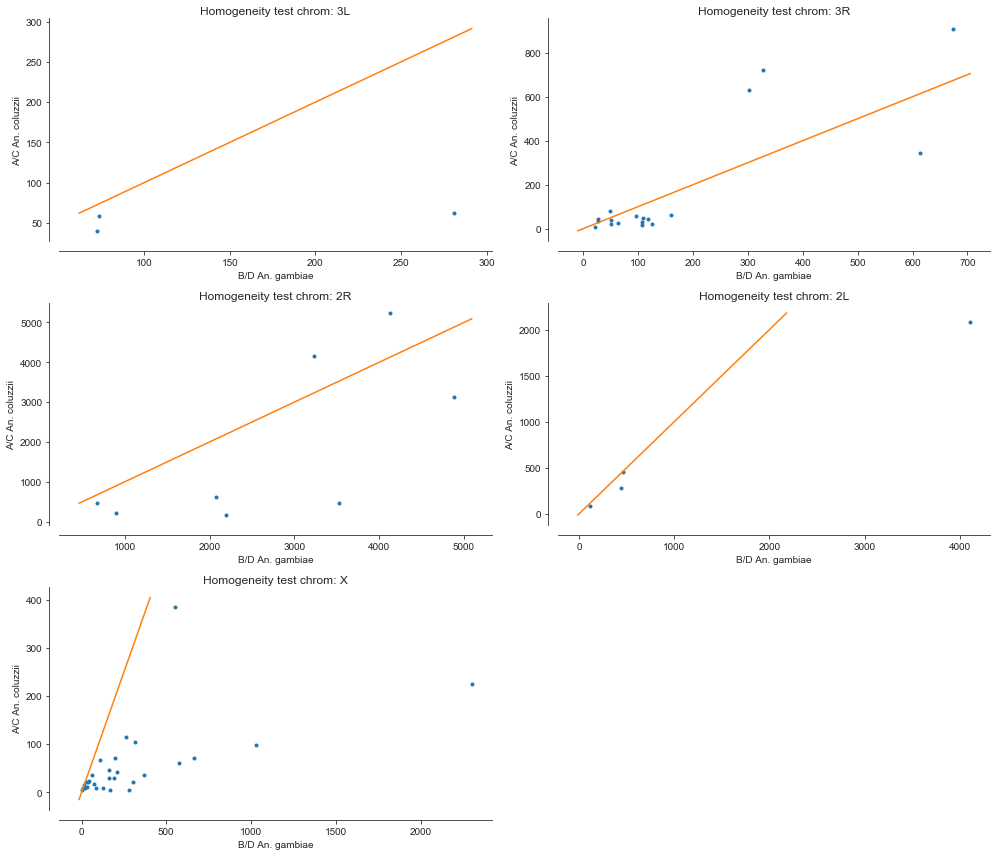

In [124]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    
    AC = joi_gambiae_coluzzii[chrom]['A/C (i.e.seg/fix)'].list()
    BD = joi_gambiae_coluzzii[chrom]['B/D (i.e.seg/fix)'].list()
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(BD, AC, '.')
    lim = max(ax.get_xlim(), ax.get_ylim())
    ax.plot(lim, lim)
    #ax.set_xlim(0,2000)
    #ax.set_ylim(0,2000)
    ax.set_title('Homogeneity test chrom: %s' % chrom)
    ax.set_ylabel('A/C An. coluzzii')
    ax.set_xlabel('B/D An. gambiae')
    sns.set_style('ticks')
    sns.despine(offset=10)

fig.tight_layout()
fig.savefig('/home/randomx/hka/homogen_test/plot_homogen_v2.png', dpi=500)

## Homogeneity test

In [125]:
joi_gambiae_coluzzii[chrom]

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP000819,2,18,9.0,2,42,21.0
AGAP000846,5,493,98.6,1,1028,1028.0
AGAP000893,1,386,386.0,1,553,553.0
AGAP000932,7,503,71.85714285714286,1,662,662.0
AGAP000934,2,43,21.5,2,77,38.5


In [126]:
def perform_homogen(joi_g_c):
    conti_tbl = {}
    pear_chi = {}
    for chrom in contigs:
        conti_tbl[chrom] = {}
        pear_chi[chrom] = {}
        for rec in joi_g_c[chrom].records():

            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[chrom][gene] = [[A, B], [C, D]]
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [127]:
pear_chi_homogen = perform_homogen(joi_gambiae_coluzzii)

In [128]:
with open('/home/randomx/hka/homogen_test/homogeneity_summary_v2.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene','score']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_homogen[chrom].items():
            row = [chrom, gene, -(np.log10((value[1])))]
            writer.writerow(row)


In [129]:
homog_tbl = (etl.fromtsv('/home/randomx/hka/homogen_test/homogeneity_summary.tab', delimiter='\t')
             .convert('score', float)
             #.select(lambda r: r.score >= 1)
             .sort(['chrom', 'score'], reverse=True)
             )
homog_tbl.displayall()

chrom,gene,score
X,AGAP001052,10.1442116077
X,AGAP001094,8.53185069818
X,AGAP001061,4.21859265094
X,AGAP001062,2.49714643681
X,AGAP001091,1.76346129566
X,AGAP000962,1.71171180744
X,AGAP001015,1.58446553611
X,AGAP000846,1.57710247058
X,AGAP000932,1.5145568376
X,AGAP000940,1.4902837639


In [130]:
join_hom_direct = homog_tbl.join(direct_select, key='gene')
join_hom_direct.displayall()

chrom,gene,score,chrom,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
3R,AGAP010293,1.0466647254,3R,69,10,33.6322381422,88,4,17.0787892782,50.7110274204


---------------------------

## Homogen selection coluzzii: (C/A > D/B)

In [131]:
for chrom in contigs:
    joi_gambiae_coluzzii[chrom] = joi_gambiae_coluzzii[chrom].addfield('chrom', chrom)


In [132]:
joi_g_c_genome = etl.cat(*joi_gambiae_coluzzii.values())
joi_g_c_genome.display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix),chrom
AGAP004827,4,1101,275.25,2,871,435.5,2L
AGAP004902,5,2250,450.0,4,1848,462.0,2L
AGAP005073,2,162,81.0,1,108,108.0,2L
AGAP005165,4,8321,2080.25,2,8229,4114.5,2L
AGAP007731,3,147,49.0,2,217,108.5,3R


In [133]:
homogen_select_coluzzii = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['C/A'] > r['D/B'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_coluzzii.displayall()

gene,chrom,score
AGAP001052,X,10.1442116077
AGAP001094,X,8.53185069818
AGAP001061,X,4.21859265094
AGAP001683,2R,2.73415701356
AGAP003997,2R,2.66652879865
AGAP001062,X,2.49714643681
AGAP007732,3R,1.82440788479
AGAP001091,X,1.76346129566
AGAP000962,X,1.71171180744
AGAP001015,X,1.58446553611


In [134]:
homogen_select_gambiae = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['D/B'] > r['C/A'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_gambiae.displayall()

gene,chrom,score
AGAP004066,2R,0.231234119473
AGAP009932,3R,0.210453340978
AGAP001050,X,0.197474462045
AGAP001824,2R,0.154120876553
AGAP007762,3R,0.153984807968
AGAP009805,3R,0.14887376915
AGAP001092,X,0.101973881525
AGAP010302,3R,0.0884305915769
AGAP007761,3R,0.0724490913028
AGAP010290,3R,0.0676351811803


## Plot the distribution of the homogen test for the top 20 genes (all genes allowed)


In [140]:
homogen_select_gambiae.rowlengths()

length,count
3,10


In [141]:
homogen_select_coluzzii.rowlengths()

length,count
3,52


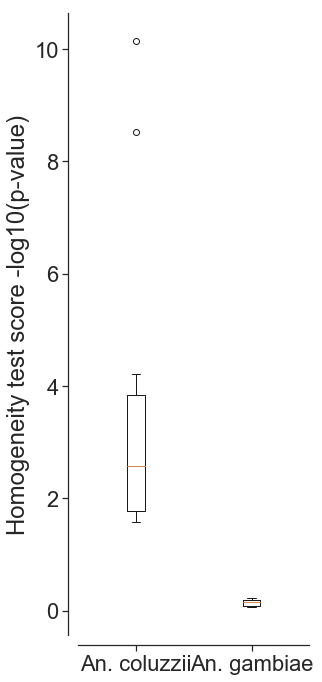

In [142]:
fig, ax = plt.subplots(figsize=(5,10))
gambiae_hom = homogen_select_gambiae['score'].list()[:10]
coluzzii_hom  = homogen_select_coluzzii['score'].list()[:10]
ax.boxplot([coluzzii_hom, gambiae_hom])
#sns.boxplot([coluzzii_hom, gambiae_hom], ax=ax)
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)

fig.tight_layout()
plt.savefig('/home/randomx/hka/homogen_test/distribution_top20_allgenes_v2.png', dpi=500)

## Plot the distribution of the homogen test genes under private selection

In [136]:
priv_sel_gambiae

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP001051,None,None,0,8,2,30.513375757
3R,AGAP010289,None,None,0,19,2,14.6459904016
X,AGAP001050,15,1,0.63691436984,25,2,11.4191397378
3R,AGAP010290,163,2,0.147753814729,195,4,7.52612592255
X,AGAP000949,None,None,0,43,2,6.86878543393


In [137]:
private_hom_gambiae = homogen_select_gambiae.join(priv_sel_gambiae, key='gene').sort('score', reverse=True)
private_hom_gambiae.rowlengths()

length,count
10,4


In [138]:
private_hom_coluzzii = homogen_select_coluzzii.join(priv_sel_coluzzii, key='gene').sort('score', reverse=True)
private_hom_coluzzii.rowlengths()

length,count
10,15


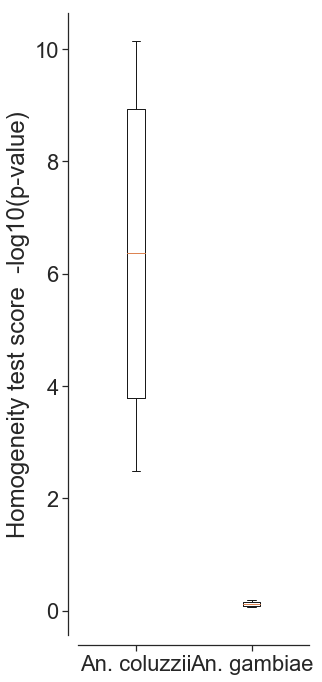

In [139]:
fig, ax = plt.subplots(figsize=(5,10))
gambiae_hom = private_hom_gambiae['score'].list()
coluzzii_hom  = private_hom_coluzzii['score'].list()[:4]
ax.boxplot([coluzzii_hom, gambiae_hom])
#sns.boxplot([coluzzii_hom, gambiae_hom], ax=ax)
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score  -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)
fig.tight_layout()
plt.savefig('/home/randomx/hka/homogen_test/distribution_top11_private_selec_v2.png', dpi=500)

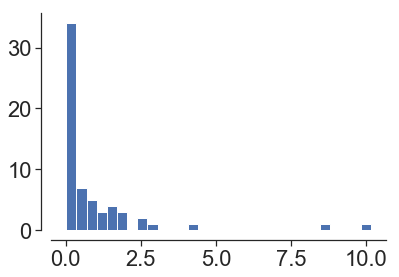

In [143]:
#plot homog score distribution
fig, ax = plt.subplots()
x = [float(i) for i in homog_tbl['score'].list()]
val = ax.hist(x, bins=30)
sns.despine(offset=10)